<a href="https://colab.research.google.com/github/arashfahim/Deep-Schemes-for-Control/blob/main/LOB_Forward_Unit_Final_6_30_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import math
import pandas as pd
import cvxpy as cp
from scipy.optimize import fsolve

In [17]:
M=2000
ite=10
dim_n=3
T=1
delta = torch.tensor(T/ite)
sigma=0.2
mu=0.3
A0=0.0
gamma=1.0-1.0/1000.0
kappa=1-gamma
rho=5
X0=100000
neuron_model_psi=20

In [18]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    # torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi_2, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [31]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(X0-1000,X0+1000)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
# print(x)
# print(x.shape)

In [32]:
def update(x3,psi):
  t=(x3[:,0]+(1/ite))
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2)
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [33]:
lr1 = 1e-1
max_epoch = 3000
optimizer = optim.Adam(model.parameters(), lr1)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.001, total_iters=3000)
#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  before_lr = optimizer.param_groups[0]["lr"]
  scheduler.step()
  after_lr = optimizer.param_groups[0]["lr"]
  if (epoch % 100==0):
    print("At epoch {} the mean error is {}.".format(epoch,cost.detach()))
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))


At epoch 0 the mean error is 1499210.25.
Epoch 0: SGD lr 0.1000 -> 0.1000
At epoch 100 the mean error is 4998153.0.
Epoch 100: SGD lr 0.0967 -> 0.0966
At epoch 200 the mean error is 4998153.0.
Epoch 200: SGD lr 0.0933 -> 0.0933
At epoch 300 the mean error is 4998153.0.
Epoch 300: SGD lr 0.0900 -> 0.0900
At epoch 400 the mean error is 4998153.0.
Epoch 400: SGD lr 0.0867 -> 0.0866
At epoch 500 the mean error is 4998153.0.
Epoch 500: SGD lr 0.0834 -> 0.0833
At epoch 600 the mean error is 4998153.0.
Epoch 600: SGD lr 0.0800 -> 0.0800
At epoch 700 the mean error is 4998153.0.
Epoch 700: SGD lr 0.0767 -> 0.0767
At epoch 800 the mean error is 4998153.0.
Epoch 800: SGD lr 0.0734 -> 0.0733
At epoch 900 the mean error is 4998153.0.
Epoch 900: SGD lr 0.0700 -> 0.0700
At epoch 1000 the mean error is 4998153.0.
Epoch 1000: SGD lr 0.0667 -> 0.0667
At epoch 1100 the mean error is 4998153.0.
Epoch 1100: SGD lr 0.0634 -> 0.0633
At epoch 1200 the mean error is 4998153.0.
Epoch 1200: SGD lr 0.0600 -> 0.0

Solution by using cvxpy package

In [22]:
def numeric_soln(X,n):
    delt=T/n
    alpa=math.exp(-delt*rho)
    c=np.ones(n)
    x=cp.Variable(n)
    #objective=cp.Minimize(determinstic_main(x))
    A=[[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            A[i][j]=1-kappa+kappa*pow(alpa,abs(i-j))
    constraints=[0<=x,sum(x)==X]

    objective=cp.Minimize(1/2*cp.quad_form(x,A))
    prob=cp.Problem(objective,constraints)
    #print("prob is DCP:", prob.is_dcp())
    #print("curvature of objective:",cp.sum(pow(x,2)).curvature)
    #assert prob.is_dqcp()
    cost=prob.solve()
    #print("Optimal value", prob.solve())
    #print("Optimal value", prob.solve(qcp=True))
    #print("Optimal soln")
    soln=x.value
    #print(soln) # A numpy ndarray
    return soln,cost

Colsed form soln


In [23]:
def closed_form(X):
  alpa=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/((ite-1)*(1-alpa)+2)
  p[ite]=X/((ite-1)*(1-alpa)+2)
  for j in range(1,ite):
    p[j]=p[0]*(1-alpa)
  return p


**Calculating cost** predicted and closed cost both have the same function. I wrote it twice because of two different data type

In [24]:
def predicted_cost(psi):
  cost=0.0
  D=0.0

  for i in range(ite+1):
    #print(D)
    cost+=D*psi[i]+(kappa/2.0)*torch.pow(psi[i],2)
    D=(D+kappa*psi[i])*torch.exp(-rho*delta)
  return cost

def closed_cost(y):
  cost1=0.0
  D1=0.0

  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the numerical solution from python convex optimization package cvxpy

In [25]:
from torch.nn.modules.pooling import MaxPool1d
M1=10
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(50, 100, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    #print(x_test)
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
c_true=np.zeros(M1)
c_pred=np.zeros(M1)
c_num=np.zeros(M1)
n_soln=np.zeros((M1,ite+1))
t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  num_soln,num_cost=numeric_soln(x1[i],ite+1)
  n_soln[i,:]=num_soln
  print('Numeric_soln',num_soln,'sum of all execution=',np.sum(num_soln))
  print('Numeric_cost=',num_cost,'\n')
  c_num[i]=num_cost

  t_soln[i,:]=closed_form(x1[i])
  print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
  true_cost=closed_cost(t_soln[i,:])
  c_true[i]=true_cost
  print('Closed form cost=',true_cost,'\n')

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
  pred_cost=predicted_cost(a[i,:])
  print('predicted cost=',pred_cost.detach().numpy(),'\n')
  c_pred[i]=pred_cost

size of total order= 50.0
Numeric_soln [9.45649329 3.4541126  3.4541126  3.4541126  3.4541126  3.4541126
 3.4541126  3.4541126  3.4541126  3.4541126  9.45649329] sum of all execution= 50.0
Numeric_cost= 1249.1364718493355 

closed form soln= [9.02327707 3.55038287 3.55038287 3.55038287 3.55038287 3.55038287
 3.55038287 3.55038287 3.55038287 3.55038287 9.02327707] sum of all execution= 49.99999999999999
Closed form cost= 0.36240428142938275 

predicted soln= tensor([4.9233, 4.6130, 4.3747, 4.1866, 4.0347, 3.9099, 3.8060, 3.7186, 3.6446,
        3.5817, 9.2068]) sum of all execution= tensor(50.0000)
predicted cost= 0.3694625 

size of total order= 55.555557
Numeric_soln [10.50721508  3.83790301  3.83790301  3.83790301  3.83790301  3.83790301
  3.83790301  3.83790301  3.83790301  3.83790301 10.50721508] sum of all execution= 55.555557250976555
Numeric_cost= 1542.1438865315758 

closed form soln= [10.02586371  3.94486998  3.94486998  3.94486998  3.94486998  3.94486998
  3.94486998  3.94486

Comparing the cost

(10,)


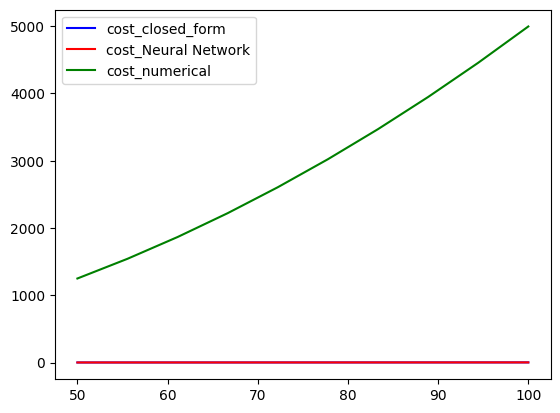

In [26]:
print(x1.shape)
plt.figure()
plt.plot(x1,c_true,color='blue',label='cost_closed_form')
plt.plot(x1,c_pred,color='red',label='cost_Neural Network')
plt.plot(x1,c_num,color='green',label='cost_numerical')
plt.legend()
plt.show()

Comparing solution for diffeternt testing samples

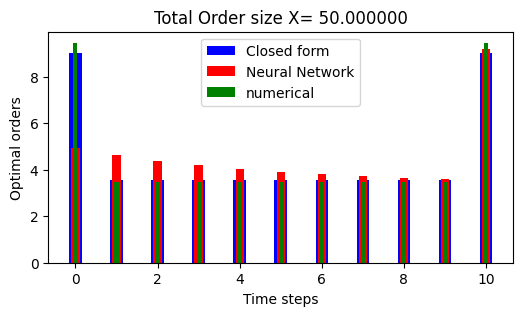

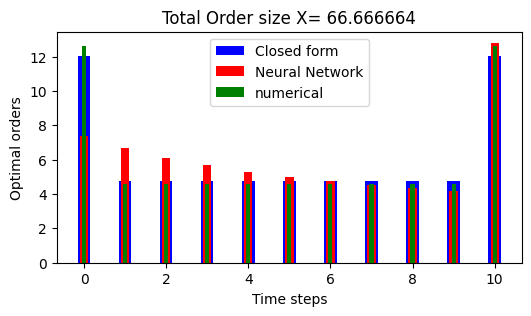

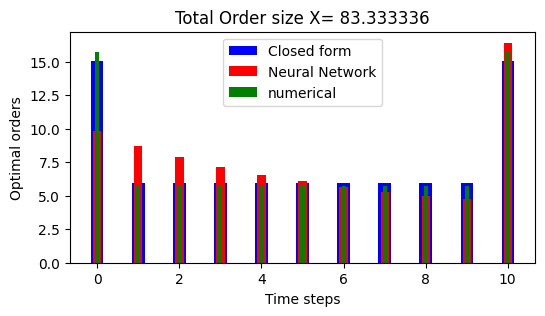

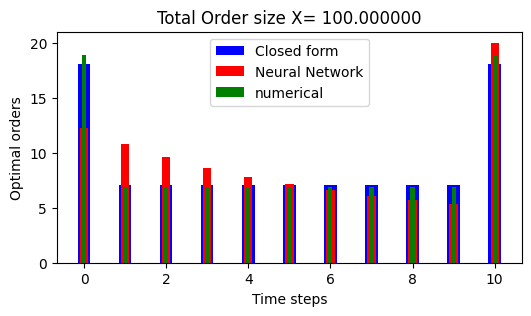

In [27]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed form')
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='Neural Network')
  plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numerical')
  plt.title('Total Order size X= %f' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show

for i in range(0,M1,3):
  plotting(i)


Comparing solution at different time steps

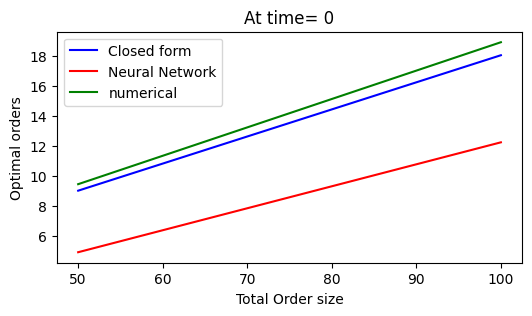

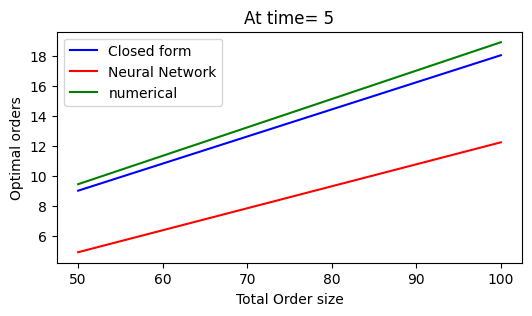

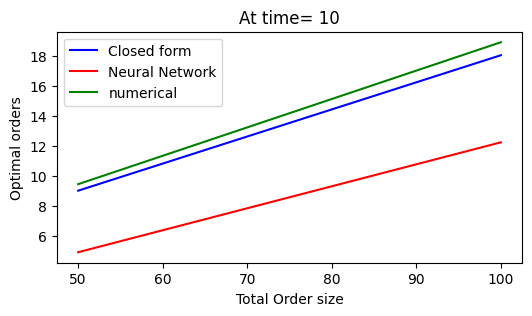

In [28]:
#p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
X=R_test.squeeze(1).numpy()
def plotting_time(t):
  #print(t_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  plt.plot(X,t_soln[:,0],color='blue',label='Closed form')
  plt.plot(X,p_soln[:,0],color='red',label='Neural Network')
  plt.plot(X,n_soln[:,0],color='green',label='numerical')
  plt.title('At time= %d' % (t_step[t]))
  plt.xlabel('Total Order size')
  plt.ylabel('Optimal orders')
  plt.legend()
  plt.show
for i in range(0,t_step.shape[0],5):
  plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

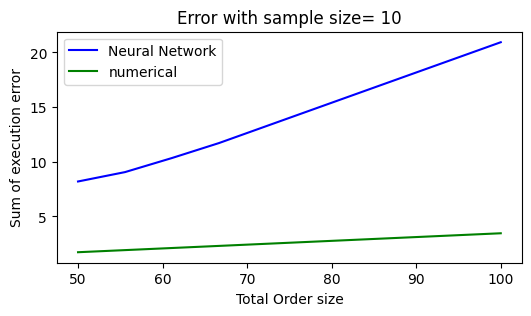

In [29]:
sq_error=np.zeros(M1)
sq_error_num=np.zeros(M1)

for i in range(M1):
  sq_error[i]=np.sum(np.abs(t_soln[i]-p_soln[i]))
  sq_error_num[i]=np.sum(np.abs(t_soln[i]-n_soln[i]))

plt.figure(figsize=(6,3))
plt.plot(X,sq_error,color='blue',label='Neural Network')
plt.plot(X,sq_error_num,color='green',label='numerical')
plt.title('Error with sample size= %d' % (M1))
plt.xlabel('Total Order size')
plt.ylabel('Sum of execution error')
plt.legend()

Additional rough test

In [30]:
# from torch.nn.modules.pooling import MaxPool1d
# M1=100
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# R_test=torch.linspace(50,100,100).unsqueeze(1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# soln=[]
# x_update = x_test
# #print(x_update)
# for i in range(ite+1):
#     #print(x_update)
#     soln_pred=model(x_update)
#     #print(soln_pred)
#     x_udpate=update(x_update,soln_pred.squeeze(1))
#     #print(x_update)
#     soln.append(soln_pred)
# strategy = torch.cat(soln,dim=1)
# print(strategy)
# # print('predicted soln=',strategy,'sum of all execution=',torch.sum(strategy,dim=1),'\n')
# a=[]
# b=[]
# c=[]
# for x in R_test:
#     a.append(x.numpy()[0])
#     y=closed_form(x.numpy()[0],ite+1)
#     #print(y)
#     b.append(y[0][0])
#     c.append(y[1])